## Prediction File
### Importing the python libraries needed to build the prediction model

Can be more advanced by applying try and catch methods (exception handling) which will install
the uninstalled libraries to the user's system.
Leaving this exception handling for now
Use this for installing uninstalled libraries:
!{sys.executable} -m pip install <libname>

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import sys
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier

### Importing training dataset from the repository

In [4]:
df=pd.read_csv('Train_final.csv')
print(df.shape)

(19948, 29)


### Applying a Null check

In [5]:
print(df.isnull().sum().sum())
df.replace(to_replace='?', value=np.nan, inplace=True)

0


#### No null values were found!! Wow!

### Describing the features statistically

In [6]:
summary=df.describe()
print(summary)

              Attr1         Attr3         Attr4         Attr5         Attr8  \
count  19948.000000  19948.000000  19948.000000  1.994800e+04  19948.000000   
mean       0.054912      0.135541      2.007517 -6.408229e+02      1.462661   
std        0.635617      0.257572      5.210927  8.582089e+04      2.394729   
min       -5.965500     -6.459000      0.019163 -1.190000e+07     -1.025300   
25%        0.004438      0.000228      1.000575 -5.795025e+01      0.396873   
50%        0.042403      0.135925      1.390500 -1.400700e+01      0.838135   
75%        0.105695      0.289357      2.126200  2.461675e+01      1.698125   
max       87.459000      0.993960    508.860000  9.909000e+05    115.190000   

              Attr9        Attr12        Attr13        Attr15        Attr16  \
count  19948.000000  19948.000000  19948.000000  1.994800e+04  19948.000000   
mean       1.444261      0.331770      0.558599  2.252917e+03      0.372496   
std        1.112802      1.951587     43.419984  8.

### Applying a check for counting the label classes

In [7]:
class_counts = df.groupby('class').size()
print(class_counts)

class
0    19525
1      423
dtype: int64


#### 0 signifies "The company is not bankrupt!" and 1 signifies "The company is bankrupt!"
#### The classes seem to be imbalanced!

### Skewness check

In [8]:
skew = df.skew()
print(skew)

Attr1     130.315359
Attr3      -1.975822
Attr4      62.523428
Attr5    -133.910775
Attr8      12.274212
Attr9      23.703574
Attr12     14.974086
Attr13     95.246892
Attr15     29.326596
Attr16      6.743684
Attr19    -80.392614
Attr20     87.590877
Attr21    101.058086
Attr22    -51.208091
Attr24     -7.331909
Attr27    124.116260
Attr28    105.860441
Attr30    108.684029
Attr32    112.656648
Attr36     10.055067
Attr37     91.084871
Attr41    141.152700
Attr47     59.573626
Attr51      6.754288
Attr53     70.103735
Attr59    109.668244
Attr65    -17.757467
Attr66   -123.362570
class       6.647308
dtype: float64


#### skewness = 0 : normally distributed.
#### skewness > 0 : more weight in the left tail of the distribution.
#### skewness < 0 : more weight in the right tail of the distribution.

### Data doesn't seem to be normally distributed!

### Correlation check

In [9]:
correlations = df.corr()
correlations

,Attr1,Attr3,Attr4,Attr5,Attr8,Attr9,Attr12,Attr13,Attr15,Attr16,...,Attr36,Attr37,Attr41,Attr47,Attr51,Attr53,Attr59,Attr65,Attr66,class
Attr1,1.000000,-0.097216,0.014319,0.000421,0.035952,0.425243,-0.054104,-0.001490,-0.001077,0.134835,...,0.415628,0.001096,0.001321,0.000384,0.257991,0.008551,-0.003821,-0.005592,-0.000963,-0.022276
Attr3,-0.097216,1.000000,0.272293,-0.000377,0.355125,-0.068744,0.184296,-0.001748,-0.003534,0.339430,...,-0.079051,0.016585,-0.000639,0.008307,-0.666646,0.057487,-0.015860,0.003778,0.004451,-0.074226
Attr4,0.014319,0.272293,1.000000,0.001031,0.278583,-0.025506,0.564424,-0.001915,-0.003792,0.215497,...,-0.052292,0.005135,-0.000849,0.000459,-0.197841,0.049584,-0.004127,0.001578,0.000867,-0.022995
Attr5,0.000421,-0.000377,0.001031,1.000000,0.003616,0.029944,0.001259,0.000104,-0.000266,0.003599,...,-0.004452,0.000279,0.000052,0.001519,-0.007933,0.000099,0.000163,0.000039,-0.000085,0.000972
Attr8,0.035952,0.355125,0.278583,0.003616,1.000000,-0.080728,0.231027,-0.003292,-0.007994,0.573304,...,-0.132842,0.030438,-0.002782,-0.005603,-0.423992,0.011496,-0.012576,0.003954,0.002130,-0.052270
Attr9,0.425243,-0.068744,-0.025506,0.029944,-0.080728,1.000000,-0.041421,-0.004335,0.003564,0.059268,...,0.668195,-0.007206,-0.000022,0.001588,0.295399,0.000203,-0.008279,-0.001800,0.001572,0.048932
Attr12,-0.054104,0.184296,0.564424,0.001259,0.231027,-0.041421,1.000000,-0.000403,-0.002194,0.402564,...,-0.042411,0.004236,0.000951,-0.003165,-0.192447,0.036975,-0.004856,0.002279,-0.000712,-0.029559
Attr13,-0.001490,-0.001748,-0.001915,0.000104,-0.003292,-0.004335,-0.000403,1.000000,-0.000239,-0.004091,...,-0.010128,-0.000357,0.000462,-0.000217,-0.000782,0.160392,0.001278,0.150059,0.000009,-0.002036
Attr15,-0.001077,-0.003534,-0.003792,-0.000266,-0.007994,0.003564,-0.002194,-0.000239,1.000000,-0.007852,...,-0.004214,-0.000511,-0.000049,-0.000400,-0.000932,0.000038,-0.000279,-0.000365,-0.000576,0.010569
Attr16,0.134835,0.339430,0.215497,0.003599,0.573304,0.059268,0.402564,-0.004091,-0.007852,1.000000,...,0.065788,0.019054,-0.001187,0.043430,-0.314306,0.013340,-0.011018,0.006855,0.000408,-0.072717


In [10]:
correlations.drop(correlations.tail(1).index,inplace=True)
correlations.drop('class', axis=1, inplace=True)  # droping the label class

In [11]:
correlations

,Attr1,Attr3,Attr4,Attr5,Attr8,Attr9,Attr12,Attr13,Attr15,Attr16,...,Attr32,Attr36,Attr37,Attr41,Attr47,Attr51,Attr53,Attr59,Attr65,Attr66
Attr1,1.000000,-0.097216,0.014319,0.000421,0.035952,0.425243,-0.054104,-0.001490,-0.001077,0.134835,...,-0.001191,0.415628,0.001096,0.001321,0.000384,0.257991,0.008551,-0.003821,-0.005592,-0.000963
Attr3,-0.097216,1.000000,0.272293,-0.000377,0.355125,-0.068744,0.184296,-0.001748,-0.003534,0.339430,...,-0.007926,-0.079051,0.016585,-0.000639,0.008307,-0.666646,0.057487,-0.015860,0.003778,0.004451
Attr4,0.014319,0.272293,1.000000,0.001031,0.278583,-0.025506,0.564424,-0.001915,-0.003792,0.215497,...,-0.004225,-0.052292,0.005135,-0.000849,0.000459,-0.197841,0.049584,-0.004127,0.001578,0.000867
Attr5,0.000421,-0.000377,0.001031,1.000000,0.003616,0.029944,0.001259,0.000104,-0.000266,0.003599,...,0.001381,-0.004452,0.000279,0.000052,0.001519,-0.007933,0.000099,0.000163,0.000039,-0.000085
Attr8,0.035952,0.355125,0.278583,0.003616,1.000000,-0.080728,0.231027,-0.003292,-0.007994,0.573304,...,-0.009265,-0.132842,0.030438,-0.002782,-0.005603,-0.423992,0.011496,-0.012576,0.003954,0.002130
Attr9,0.425243,-0.068744,-0.025506,0.029944,-0.080728,1.000000,-0.041421,-0.004335,0.003564,0.059268,...,0.013148,0.668195,-0.007206,-0.000022,0.001588,0.295399,0.000203,-0.008279,-0.001800,0.001572
Attr12,-0.054104,0.184296,0.564424,0.001259,0.231027,-0.041421,1.000000,-0.000403,-0.002194,0.402564,...,-0.003691,-0.042411,0.004236,0.000951,-0.003165,-0.192447,0.036975,-0.004856,0.002279,-0.000712
Attr13,-0.001490,-0.001748,-0.001915,0.000104,-0.003292,-0.004335,-0.000403,1.000000,-0.000239,-0.004091,...,-0.000629,-0.010128,-0.000357,0.000462,-0.000217,-0.000782,0.160392,0.001278,0.150059,0.000009
Attr15,-0.001077,-0.003534,-0.003792,-0.000266,-0.007994,0.003564,-0.002194,-0.000239,1.000000,-0.007852,...,-0.000351,-0.004214,-0.000511,-0.000049,-0.000400,-0.000932,0.000038,-0.000279,-0.000365,-0.000576
Attr16,0.134835,0.339430,0.215497,0.003599,0.573304,0.059268,0.402564,-0.004091,-0.007852,1.000000,...,0.049007,0.065788,0.019054,-0.001187,0.043430,-0.314306,0.013340,-0.011018,0.006855,0.000408


### Plotting correlation matrix to view the correlation graphically!

<AxesSubplot:>

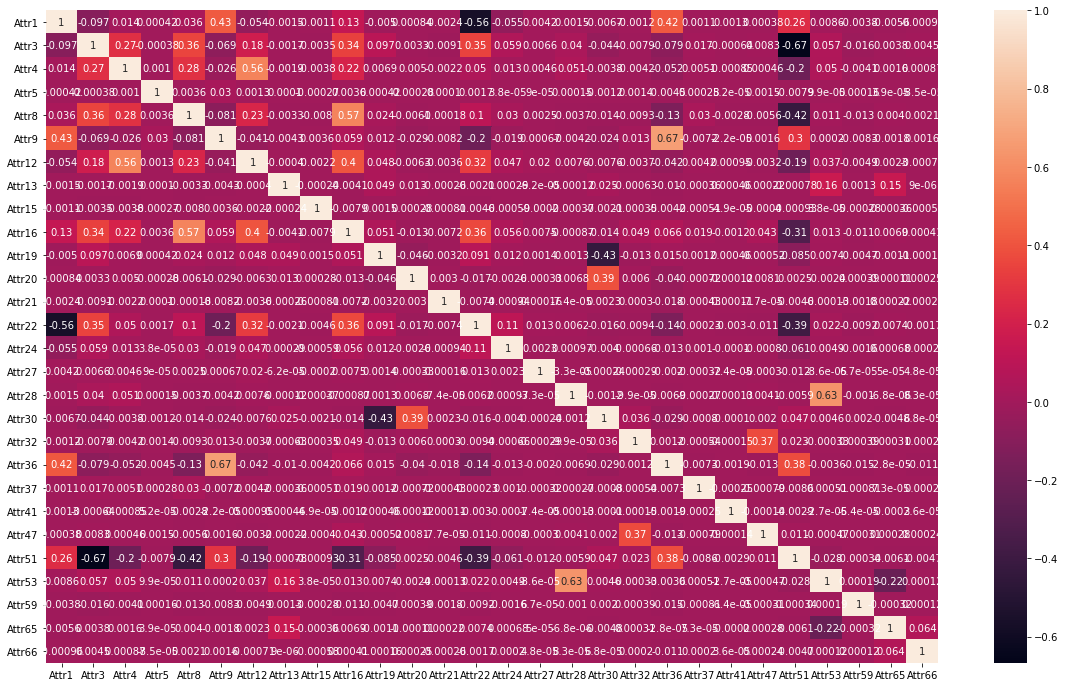

In [12]:
pyplot.figure(figsize=(20,12))
import seaborn as sns
sns.heatmap(correlations, annot=True)

### Please ignore the below cell for now
Not removing it for now

In [ ]:
"""
# plot correlation matrix
fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
#ax.set_xticklabels(names)
#ax.set_yticklabels(names)
pyplot.show()
"""

### Correlation with class
The point biserial correlation is used to measure the 
relationship between a binary variable, x, and a continuous variable, y

<BarContainer object of 28 artists>

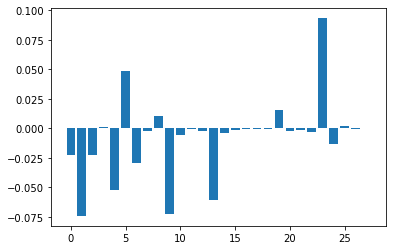

In [13]:
cor=[]
for i in range(0,df.shape[1]-1):
    r= stats.pointbiserialr(df['class'], df[df.columns[i]])[0]
    cor.append(r)

pyplot.bar(np.arange(28),cor)

### Defining features(X) and label(Y)

In [14]:
X=df.iloc[ : , :-1].values
Y=df.iloc[ : ,-1].values 

### Standardizing the features

In [15]:
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)

### Would use the below algorithms for building the model

In [16]:
models = []
models.append(('LR', LogisticRegression(class_weight = 'balanced')))
models.append(('DT', DecisionTreeClassifier(class_weight = 'balanced')))
models.append(('BDT',BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),sampling_strategy='auto',replacement=False,random_state=0)))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier(class_weight = 'balanced')))
models.append(('BRF',BalancedRandomForestClassifier(random_state=0))) #each tree of the forest will be provided a balanced bootstrap sample
models.append(('GB', GradientBoostingClassifier()))
models.append(('SGD', SGDClassifier(class_weight = 'balanced')))
models.append(('ADA', AdaBoostClassifier()))
models.append(('EEC',EasyEnsembleClassifier(random_state=0))) #bag AdaBoost learners which are trained on balanced bootstrap samples 
models.append(('XGB', XGBClassifier()))
models.append(('RUS',RUSBoostClassifier(random_state=0))) #randomly under-sample the dataset before to perform a boosting iteration 
models.append(('MLP',MLPClassifier()))

#### Ignoring warnings for now, to see a clear output!

In [17]:
import warnings
warnings.filterwarnings('ignore')

## Evaluating each model in turn

In [18]:
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    kfold = StratifiedKFold(n_splits=5)
    cv_results = cross_val_score(model, rescaledX, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(name, cv_results.mean(), cv_results.std())

LR 0.7978016978878619 0.02232958941221305
DT 0.5409666914140816 0.023371096317465014
BDT 0.8476307004235754 0.016603612744703726
NB 0.5352121391450306 0.016602403146278505
RF 0.8211981084367166 0.027588432798561165
BRF 0.8628304802074478 0.019051472797653287
GB 0.8648450811822809 0.010802977235740857
SGD 0.7807082351506544 0.02587678799765994
ADA 0.8462812597510195 0.008906155003313912
EEC 0.8489002069457744 0.012383352036720727
[15:54:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set ev

### Comparing the Algorithm results using a boxplot

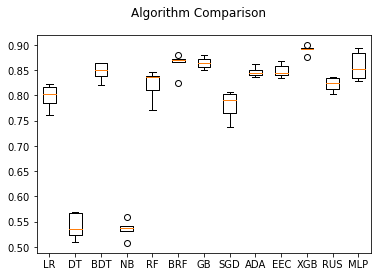

In [19]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Hyperparameter Tuning
#### Commenting for now as this would take a lot of time to run on a small system/machine.
#### The best paramenters deduced are displayed in the next cell.

In [30]:
"""
# starting time
import time
start = time.time()

xgb_model = XGBClassifier(random_state=10)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
#
parameters = {'nthread':[4], #Using hyperthread slows down the xgboost run time
              'objective':['binary:logistic'],
              'learning_rate': [0.05, 0.1], #so called `eta` value
              'max_depth': [4,5,6],
              'min_child_weight': [1],
              'silent': [1],
              'gamma':[0],
              'subsample': [0.6,0.8,0.9],
              'colsample_bytree': [0.7],
              'n_estimators': [1000], #number of trees, 1000 for better results
              'missing':[-999],
              'scale_pos_weight':[1],
              'seed': [10]}
#
#
clf = GridSearchCV(xgb_model, parameters, n_jobs=-1, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(rescaledX, Y)
#
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
#
#
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    
# end time
end = time.time()

# total time taken
print(f"Runtime on different fits is {end - start}") # Returns the current time in seconds since the Epoch.
test_probs = clf.predict_proba(X_test)[:,1]

"""

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[04:05:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.892 (+/-0.017) for {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'missing': -999, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'seed': 10, 's

These are the best hyperparameters deduced using GridSearch CV:

0.895 (+/-0.009) 
{'colsample_bytree': 0.7, 
'gamma': 0, 
'learning_rate': 0.05, 
'max_depth': 6,
'min_child_weight': 1,
'missing': -999,
'n_estimators': 1000,
'nthread': 4,
'objective': 'binary:logistic',
'scale_pos_weight': 1, 
'seed': 10, 
'silent': 1, 
'subsample': 0.6}

### Calculating the feature importance

[16:02:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:02:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


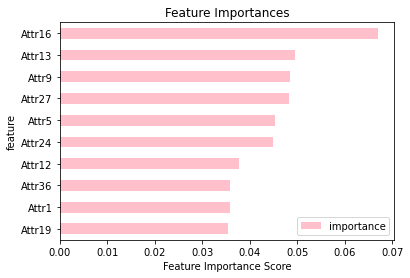

In [20]:
xgb_model = XGBClassifier(learning_rate =0.05, n_estimators=1000, max_depth=6,
 min_child_weight=1, gamma=0, subsample=0.6, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=10, missing=-999, silent=1)

xgb_model.fit(rescaledX, Y)
feat_imp = pd.DataFrame({'importance':xgb_model.feature_importances_})    
feat_imp['feature'] = df.columns[:-1]
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:10]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title="Feature Importances", color = 'pink')
pyplot.xlabel('Feature Importance Score')
pyplot.show()

## EVALUATION METRICS

In [21]:
from sklearn.model_selection import cross_validate

score=['roc_auc','f1_weighted']

kfold = StratifiedKFold(n_splits=5)
cv_results = cross_validate(xgb_model, rescaledX, Y, cv=kfold, scoring=score)
print(cv_results)

[16:05:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:05:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:05:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but 

## Learning curve

#### Takes a long time to run on a low RAM CPU

In [22]:
# start time
start = time.time()

from sklearn.model_selection import learning_curve
 # Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(XGBClassifier(), 
                                               rescaledX, Y, cv=kfold, scoring='roc_auc', n_jobs=-1, 
                                               # 50 different sizes of the training set
                                               train_sizes=np.linspace(0.5, 1.0, 50))

# end time
end = time.time()

# total time taken
print(f"Runtime for learning_curve is {end - start}") # Returns the time taken for run (in seconds).

In [23]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

In [24]:
# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

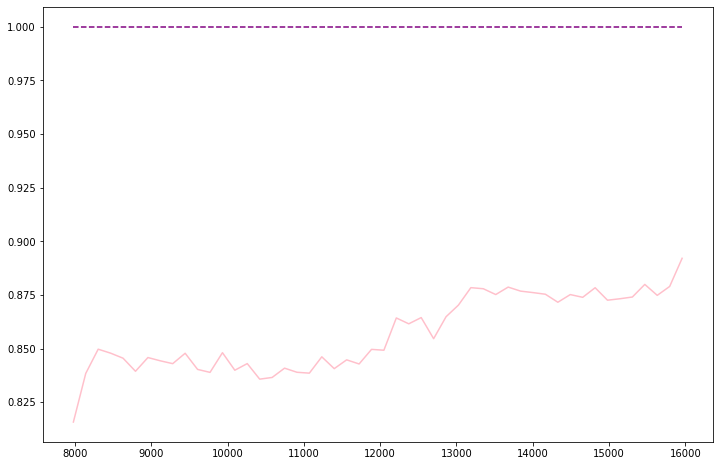

In [25]:
# Draw lines
pyplot.subplots(figsize=(12,8))
pyplot.plot(train_sizes, train_mean, '--', color="purple",  label="Training score")
pyplot.plot(train_sizes, test_mean, color="pink", label="Cross-validation score")

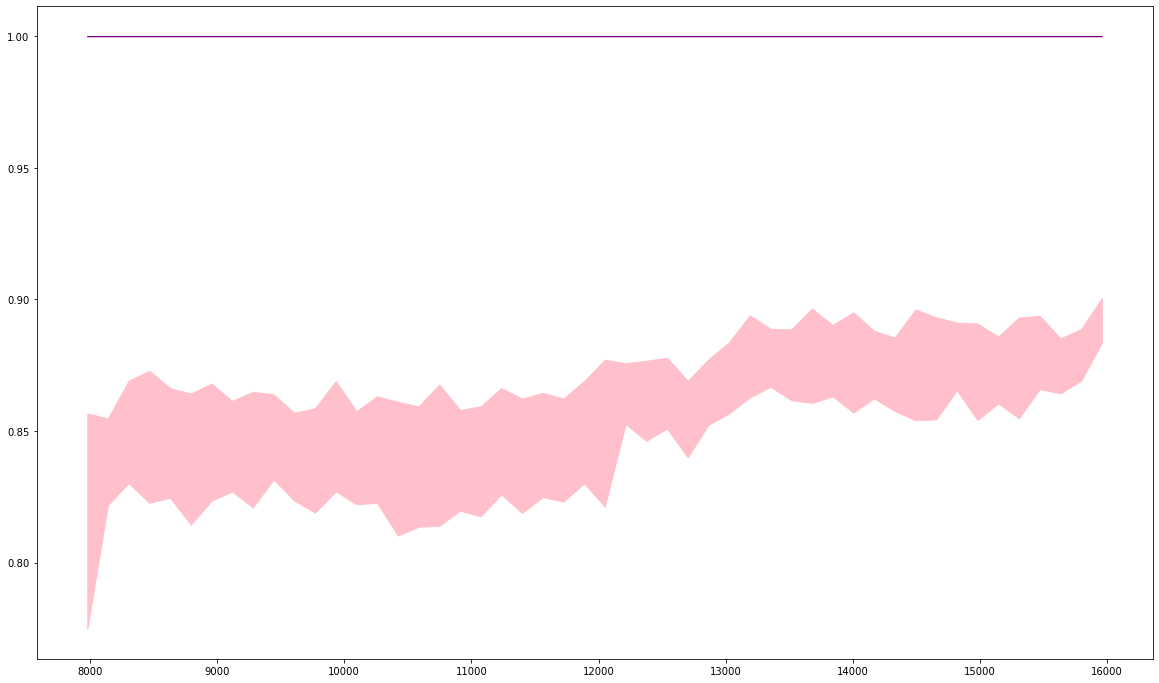

In [26]:
# Draw bands
pyplot.subplots(figsize=(20,12))
pyplot.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="purple")
pyplot.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="pink")

No handles with labels found to put in legend.


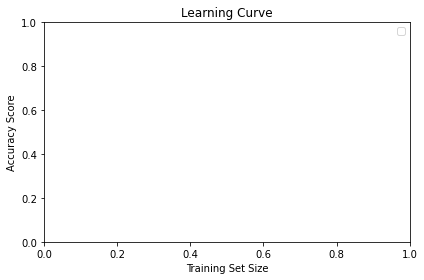

In [27]:
# Create plot
pyplot.title("Learning Curve")
pyplot.xlabel("Training Set Size") 
pyplot.ylabel("Accuracy Score") 
pyplot.legend(loc="best")
pyplot.tight_layout() 
pyplot.show()

In [ ]:
#!{sys.executable} -m pip install graphviz
# extra step to allow graphviz to be found 
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/jed/Anaconda3/envs/keras/Library/bin/graphviz/'
import graphviz
from xgboost import plot_tree
plot_tree(xgb_model, num_trees=1)
fig = pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree1.png')

In [28]:
###############Save load and testing the model
from sklearn.pipeline import Pipeline
import pickle
pipeline = Pipeline([('scaler', StandardScaler()), ('xgb_model', XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.6, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=10, missing=-999, silent=1))])
pipeline.fit(X, Y)
pickle.dump(pipeline, open('comp', 'wb'))
fin = pickle.load(open('comp', 'rb'))
#ynew = fin.predict(np.array(X_test).reshape(1,28))
#ynew_prob = fin.predict_proba(np.array(X_test).reshape(1,28))[:,1]
#print(ynew,ynew_prob)

[16:26:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
df2=pd.read_csv('test.csv')
print(df2.shape)

(432, 29)


In [30]:
cl=[]
prob=[]
for i in range(df2.shape[0]):
    a=df2.iloc[ i , :-1].values
    ynew = fin.predict(np.array(a).reshape(1,28))
    ynew_prob = fin.predict_proba(np.array(a).reshape(1,28))[:,1]
    print(ynew,ynew_prob)
    cl.append(ynew)
    prob.append(ynew_prob)

[0] [0.00351575]
[1] [0.9494244]
[1] [0.96002257]
[1] [0.89449024]
[1] [0.9780707]
[1] [0.8701666]
[1] [0.94717544]
[1] [0.86018586]
[1] [0.95385]
[1] [0.9516505]
[1] [0.88079184]
[1] [0.87305194]
[1] [0.94760245]
[1] [0.9618138]
[1] [0.95958656]
[1] [0.82239294]
[1] [0.857704]
[1] [0.83286494]
[1] [0.9822811]
[1] [0.9611724]
[1] [0.9323496]
[1] [0.96057254]
[1] [0.92323667]
[1] [0.9460207]
[1] [0.8828807]
[1] [0.89785075]
[1] [0.95066565]
[1] [0.97129804]
[1] [0.9728679]
[1] [0.90846187]
[1] [0.8726912]
[1] [0.9549872]
[1] [0.9723309]
[1] [0.9668659]
[1] [0.92816556]
[1] [0.8427952]
[1] [0.96246886]
[1] [0.9220282]
[1] [0.9607138]
[1] [0.8693184]
[1] [0.97493017]
[1] [0.94432306]
[1] [0.9488284]
[1] [0.9621052]
[1] [0.9794428]
[1] [0.94167674]
[1] [0.9626481]
[1] [0.91531014]
[1] [0.9863979]
[1] [0.96888006]
[1] [0.8993639]
[1] [0.9625572]
[1] [0.9470982]
[1] [0.85789055]
[1] [0.9382776]
[1] [0.91029453]
[1] [0.95138174]
[1] [0.94120795]
[1] [0.87762487]
[1] [0.89902025]
[1] [0.956283

In [31]:
accuracy=sum(cl)/df2.shape[0]*100
print(sum(cl), df2.shape[0], accuracy)


[425] 432 [98.37962963]
